## Data Prepare & Labeled

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

In [3]:
# df = pd.read_excel('dataset/redbook.xlsx')
# label_df = df.sample(1000)
# label_df.to_csv('dataset/sample_1000.csv')

In [4]:
sample_df = pd.read_excel('dataset/sample_1000.xlsx')
sample_df['category'] = sample_df['情感倾向'].apply(lambda x: 'O' if x == '其他' else x)

### EDA

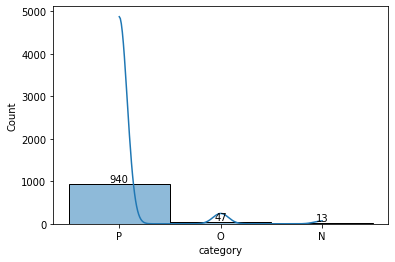

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

y = sns.histplot(sample_df['category'], kde=True, stat="count")
y.bar_label(y.containers[0])
plt.show()

### Text vectorization

In [6]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('uer/roberta-base-finetuned-dianping-chinese')

### Model

In [7]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('uer/roberta-base-finetuned-dianping-chinese')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 3)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

### DataLoader

In [8]:
import torch
import numpy as np

labels = {'N': 0,
          'P': 1,
          'O': 2
          }


class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):

        self.labels = [labels[label] for label in df['category']]
        self.texts = [
            tokenizer(
                str(row["title"]) + " " + str(row["content"]),
                padding="max_length",
                max_length=512,
                truncation=True,
                return_tensors="pt",
            )
            for _, row in df.iterrows()
        ]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        try:
            return np.array(self.labels[idx])
        except:
            print(idx)
            print(self.labels)

    def get_batch_texts(self, idx):
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y


### Training

In [9]:
import torch
import os
from torch.optim import Adam
from tqdm import tqdm
from sklearn.metrics import classification_report

def train(model, train_data, val_data, learning_rate, epochs, log_dir='./model', continue_train_path='./model/bert_training_model.pth'):

    train, val = Dataset(train_data), Dataset(val_data)

    train_target = torch.tensor(train.labels, dtype=torch.long)
    train_class_sample_count = torch.tensor([(train_target == t).sum() for t in torch.unique(train_target, sorted=True)])
    train_weight = 1. / train_class_sample_count.float()
    train_samples_weight = torch.tensor([train_weight[t] for t in train_target])

    train_dataloader = torch.utils.data.DataLoader(
        train, batch_size=2, 
        sampler=torch.utils.data.WeightedRandomSampler(train_samples_weight, len(train_samples_weight), replacement=True)
    )
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    # criterion = torch.hub.load(
    #     'adeelh/pytorch-multi-class-focal-loss',
    #     model='FocalLoss',
    #     alpha=train_weight,
    #     gamma=3,
    #     reduction='mean',
    #     force_reload=False
    # )
    criterion = nn.CrossEntropyLoss(weight=train_weight)

    start_epoch = 0
    optimizer = Adam(model.parameters(), lr=learning_rate)
    if os.path.exists(continue_train_path):
        checkpoint = torch.load(continue_train_path)
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        start_epoch = checkpoint['epoch']

    if use_cuda:

        model = model.cuda()
        criterion = criterion.cuda()

    best_model = None
    best_optimizer = None
    best_epoch = None
    best_val_loss = 0


    for epoch in range(start_epoch+1, epochs):

        total_acc_train = 0
        total_loss_train = 0
        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input["attention_mask"].to(device)
            input_id = train_input["input_ids"].squeeze(1).to(device)

            output = model(input_id, mask)

            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()

            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        total_acc_val = 0
        total_loss_val = 0

        val_pred = []
        with torch.no_grad():

            for val_input, val_label in val_dataloader:

                val_label = val_label.to(device)
                mask = val_input["attention_mask"].to(device)
                input_id = val_input["input_ids"].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()

                batch_val_pred = output.argmax(dim=1)
                val_pred = val_pred + batch_val_pred.tolist()
                acc = (batch_val_pred == val_label).sum().item()
                total_acc_val += acc

        var_acc = total_acc_val / len(val_data)
        var_loss = total_loss_val / len(val_data)
        print(
            f"Epochs: {epoch + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {var_loss: .3f} \
                | Val Accuracy: {var_acc: .3f} \
                | Val classification_report:\n {classification_report(val.labels, val_pred)}"
        )

        if best_val_loss > var_loss:
            best_val_loss = var_loss
            best_model = model
            best_optimizer = optimizer
            best_epoch = epoch
            # save model
            torch.save({
                'model': best_model.state_dict(),
                'optimizer': best_optimizer.state_dict(),
                'epoch': best_epoch
            }, f'{log_dir}/bert_best_model.pth')
        
        # save model
        torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch
        }, f'{log_dir}/bert_training_model.pth')


### Evaluate

In [10]:
import torch

def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    test_pred = []
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            batch_test_pred = output.argmax(dim=1)
            test_pred = test_pred + batch_test_pred.tolist()
            acc = (batch_test_pred == test_label).sum().item()
            total_acc_test += acc

    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return test_pred, test.labels


### Split data

In [11]:
import numpy as np

df_train, df_val, df_test = np.split(
    sample_df.sample(frac=1, random_state=42),
    [int(0.8 * len(sample_df)), int(0.9 * len(sample_df))],
)

In [12]:
EPOCHS = 20
model = BertClassifier()
LR = 1e-6

np.random.seed(112)

########## TODO: random labeled############
# sample_df['category'] = np.random.randint(0,4, size=len(sample_df))

print(len(df_train), len(df_val), len(df_test))

train(model, df_train.reset_index(drop=True), df_val.reset_index(drop=True), LR, EPOCHS)


Some weights of the model checkpoint at uer/roberta-base-finetuned-dianping-chinese were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


800 100 100


100%|██████████| 500/500 [01:00<00:00,  8.29it/s]


Epochs: 2 | Train Loss:  0.502                 | Train Accuracy:  0.583                 | Val Loss:  0.546                 | Val Accuracy:  0.280                 | Val classification_report:
               precision    recall  f1-score   support

           0       0.08      1.00      0.15         2
           1       1.00      0.25      0.40        95
           2       0.04      0.67      0.07         3

    accuracy                           0.28       100
   macro avg       0.37      0.64      0.21       100
weighted avg       0.95      0.28      0.39       100



100%|██████████| 500/500 [01:00<00:00,  8.27it/s]


Epochs: 3 | Train Loss:  0.343                 | Train Accuracy:  0.659                 | Val Loss:  0.606                 | Val Accuracy:  0.170                 | Val classification_report:
               precision    recall  f1-score   support

           0       0.08      1.00      0.15         2
           1       1.00      0.14      0.24        95
           2       0.03      0.67      0.06         3

    accuracy                           0.17       100
   macro avg       0.37      0.60      0.15       100
weighted avg       0.95      0.17      0.23       100



100%|██████████| 500/500 [01:00<00:00,  8.27it/s]


Epochs: 4 | Train Loss:  0.188                 | Train Accuracy:  0.729                 | Val Loss:  0.562                 | Val Accuracy:  0.340                 | Val classification_report:
               precision    recall  f1-score   support

           0       0.09      1.00      0.16         2
           1       1.00      0.32      0.48        95
           2       0.04      0.67      0.08         3

    accuracy                           0.34       100
   macro avg       0.38      0.66      0.24       100
weighted avg       0.95      0.34      0.46       100



100%|██████████| 500/500 [01:00<00:00,  8.24it/s]


Epochs: 5 | Train Loss:  0.156                 | Train Accuracy:  0.839                 | Val Loss:  0.339                 | Val Accuracy:  0.740                 | Val classification_report:
               precision    recall  f1-score   support

           0       0.17      1.00      0.29         2
           1       1.00      0.74      0.85        95
           2       0.11      0.67      0.19         3

    accuracy                           0.74       100
   macro avg       0.43      0.80      0.44       100
weighted avg       0.96      0.74      0.82       100



100%|██████████| 500/500 [01:00<00:00,  8.23it/s]


Epochs: 6 | Train Loss:  0.102                 | Train Accuracy:  0.895                 | Val Loss:  0.243                 | Val Accuracy:  0.820                 | Val classification_report:
               precision    recall  f1-score   support

           0       0.25      1.00      0.40         2
           1       1.00      0.82      0.90        95
           2       0.14      0.67      0.24         3

    accuracy                           0.82       100
   macro avg       0.46      0.83      0.51       100
weighted avg       0.96      0.82      0.87       100



100%|██████████| 500/500 [01:00<00:00,  8.24it/s]


Epochs: 7 | Train Loss:  0.077                 | Train Accuracy:  0.934                 | Val Loss:  0.189                 | Val Accuracy:  0.860                 | Val classification_report:
               precision    recall  f1-score   support

           0       0.33      1.00      0.50         2
           1       1.00      0.85      0.92        95
           2       0.23      1.00      0.38         3

    accuracy                           0.86       100
   macro avg       0.52      0.95      0.60       100
weighted avg       0.96      0.86      0.90       100



100%|██████████| 500/500 [01:00<00:00,  8.22it/s]


Epochs: 8 | Train Loss:  0.049                 | Train Accuracy:  0.951                 | Val Loss:  0.116                 | Val Accuracy:  0.910                 | Val classification_report:
               precision    recall  f1-score   support

           0       0.40      1.00      0.57         2
           1       1.00      0.92      0.96        95
           2       0.25      0.67      0.36         3

    accuracy                           0.91       100
   macro avg       0.55      0.86      0.63       100
weighted avg       0.97      0.91      0.93       100



100%|██████████| 500/500 [01:00<00:00,  8.22it/s]


Epochs: 9 | Train Loss:  0.029                 | Train Accuracy:  0.970                 | Val Loss:  0.106                 | Val Accuracy:  0.910                 | Val classification_report:
               precision    recall  f1-score   support

           0       0.33      1.00      0.50         2
           1       1.00      0.92      0.96        95
           2       0.29      0.67      0.40         3

    accuracy                           0.91       100
   macro avg       0.54      0.86      0.62       100
weighted avg       0.97      0.91      0.93       100



100%|██████████| 500/500 [01:00<00:00,  8.25it/s]


Epochs: 10 | Train Loss:  0.022                 | Train Accuracy:  0.973                 | Val Loss:  0.084                 | Val Accuracy:  0.940                 | Val classification_report:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.94      0.97        95
           2       0.38      1.00      0.55         3

    accuracy                           0.94       100
   macro avg       0.68      0.98      0.77       100
weighted avg       0.97      0.94      0.95       100



100%|██████████| 500/500 [01:00<00:00,  8.23it/s]


Epochs: 11 | Train Loss:  0.029                 | Train Accuracy:  0.971                 | Val Loss:  0.080                 | Val Accuracy:  0.940                 | Val classification_report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.94      0.97        95
           2       0.33      1.00      0.50         3

    accuracy                           0.94       100
   macro avg       0.78      0.98      0.82       100
weighted avg       0.98      0.94      0.95       100



100%|██████████| 500/500 [01:00<00:00,  8.22it/s]


Epochs: 12 | Train Loss:  0.018                 | Train Accuracy:  0.985                 | Val Loss:  0.067                 | Val Accuracy:  0.940                 | Val classification_report:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.94      0.97        95
           2       0.38      1.00      0.55         3

    accuracy                           0.94       100
   macro avg       0.68      0.98      0.77       100
weighted avg       0.97      0.94      0.95       100



100%|██████████| 500/500 [01:00<00:00,  8.23it/s]


Epochs: 13 | Train Loss:  0.015                 | Train Accuracy:  0.990                 | Val Loss:  0.054                 | Val Accuracy:  0.950                 | Val classification_report:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.95      0.97        95
           2       0.43      1.00      0.60         3

    accuracy                           0.95       100
   macro avg       0.70      0.98      0.79       100
weighted avg       0.98      0.95      0.96       100



100%|██████████| 500/500 [01:00<00:00,  8.22it/s]


Epochs: 14 | Train Loss:  0.011                 | Train Accuracy:  0.994                 | Val Loss:  0.058                 | Val Accuracy:  0.960                 | Val classification_report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.96      0.98        95
           2       0.43      1.00      0.60         3

    accuracy                           0.96       100
   macro avg       0.81      0.99      0.86       100
weighted avg       0.98      0.96      0.97       100



100%|██████████| 500/500 [01:00<00:00,  8.22it/s]


Epochs: 15 | Train Loss:  0.014                 | Train Accuracy:  0.986                 | Val Loss:  0.035                 | Val Accuracy:  0.970                 | Val classification_report:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.97      0.98        95
           2       0.60      1.00      0.75         3

    accuracy                           0.97       100
   macro avg       0.76      0.99      0.84       100
weighted avg       0.98      0.97      0.97       100



100%|██████████| 500/500 [01:00<00:00,  8.23it/s]


Epochs: 16 | Train Loss:  0.006                 | Train Accuracy:  0.997                 | Val Loss:  0.035                 | Val Accuracy:  0.970                 | Val classification_report:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.97      0.98        95
           2       0.60      1.00      0.75         3

    accuracy                           0.97       100
   macro avg       0.76      0.99      0.84       100
weighted avg       0.98      0.97      0.97       100



100%|██████████| 500/500 [01:00<00:00,  8.21it/s]


Epochs: 17 | Train Loss:  0.008                 | Train Accuracy:  0.995                 | Val Loss:  0.037                 | Val Accuracy:  0.970                 | Val classification_report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.97      0.98        95
           2       0.50      1.00      0.67         3

    accuracy                           0.97       100
   macro avg       0.83      0.99      0.88       100
weighted avg       0.98      0.97      0.97       100



100%|██████████| 500/500 [01:00<00:00,  8.21it/s]


Epochs: 18 | Train Loss:  0.004                 | Train Accuracy:  0.995                 | Val Loss:  0.037                 | Val Accuracy:  0.970                 | Val classification_report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.97      0.98        95
           2       0.50      1.00      0.67         3

    accuracy                           0.97       100
   macro avg       0.83      0.99      0.88       100
weighted avg       0.98      0.97      0.97       100



100%|██████████| 500/500 [01:00<00:00,  8.23it/s]


Epochs: 19 | Train Loss:  0.006                 | Train Accuracy:  0.993                 | Val Loss:  0.036                 | Val Accuracy:  0.970                 | Val classification_report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.97      0.98        95
           2       0.50      1.00      0.67         3

    accuracy                           0.97       100
   macro avg       0.83      0.99      0.88       100
weighted avg       0.98      0.97      0.97       100



100%|██████████| 500/500 [01:00<00:00,  8.21it/s]


Epochs: 20 | Train Loss:  0.007                 | Train Accuracy:  0.996                 | Val Loss:  0.035                 | Val Accuracy:  0.970                 | Val classification_report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.97      0.98        95
           2       0.50      1.00      0.67         3

    accuracy                           0.97       100
   macro avg       0.83      0.99      0.88       100
weighted avg       0.98      0.97      0.97       100



In [20]:
# load best bert model
model = BertClassifier()
checkpoint = torch.load('./model/bert_training_model.pth')
model.load_state_dict(checkpoint['model'])
#evaluate
test_pred, test_target = evaluate(model, df_test.reset_index(drop=True))

Some weights of the model checkpoint at uer/roberta-base-finetuned-dianping-chinese were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Test Accuracy:  0.990


### Classification report

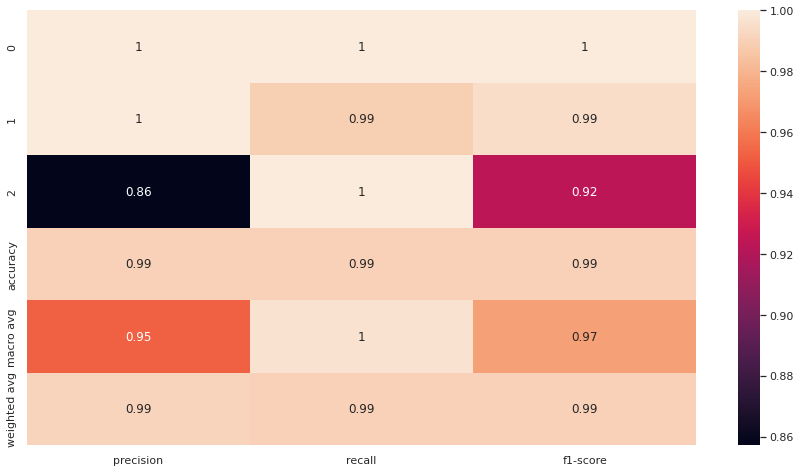

In [21]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

gin_clf_report = classification_report(test_target, test_pred, output_dict=True)
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(pd.DataFrame(gin_clf_report).iloc[:-1, :].T, annot=True)
plt.show()

### EDA

In [15]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt

def generate_word_cloud(result):
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        font_path = './font/HYShangWeiShouShuW.ttf',
        background_color = 'black'
    ).generate_from_frequencies(result)
    fig = plt.figure(
        figsize = (40, 30),
        facecolor = 'k',
        edgecolor = 'k'
    )
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.757 seconds.
Prefix dict has been built successfully.


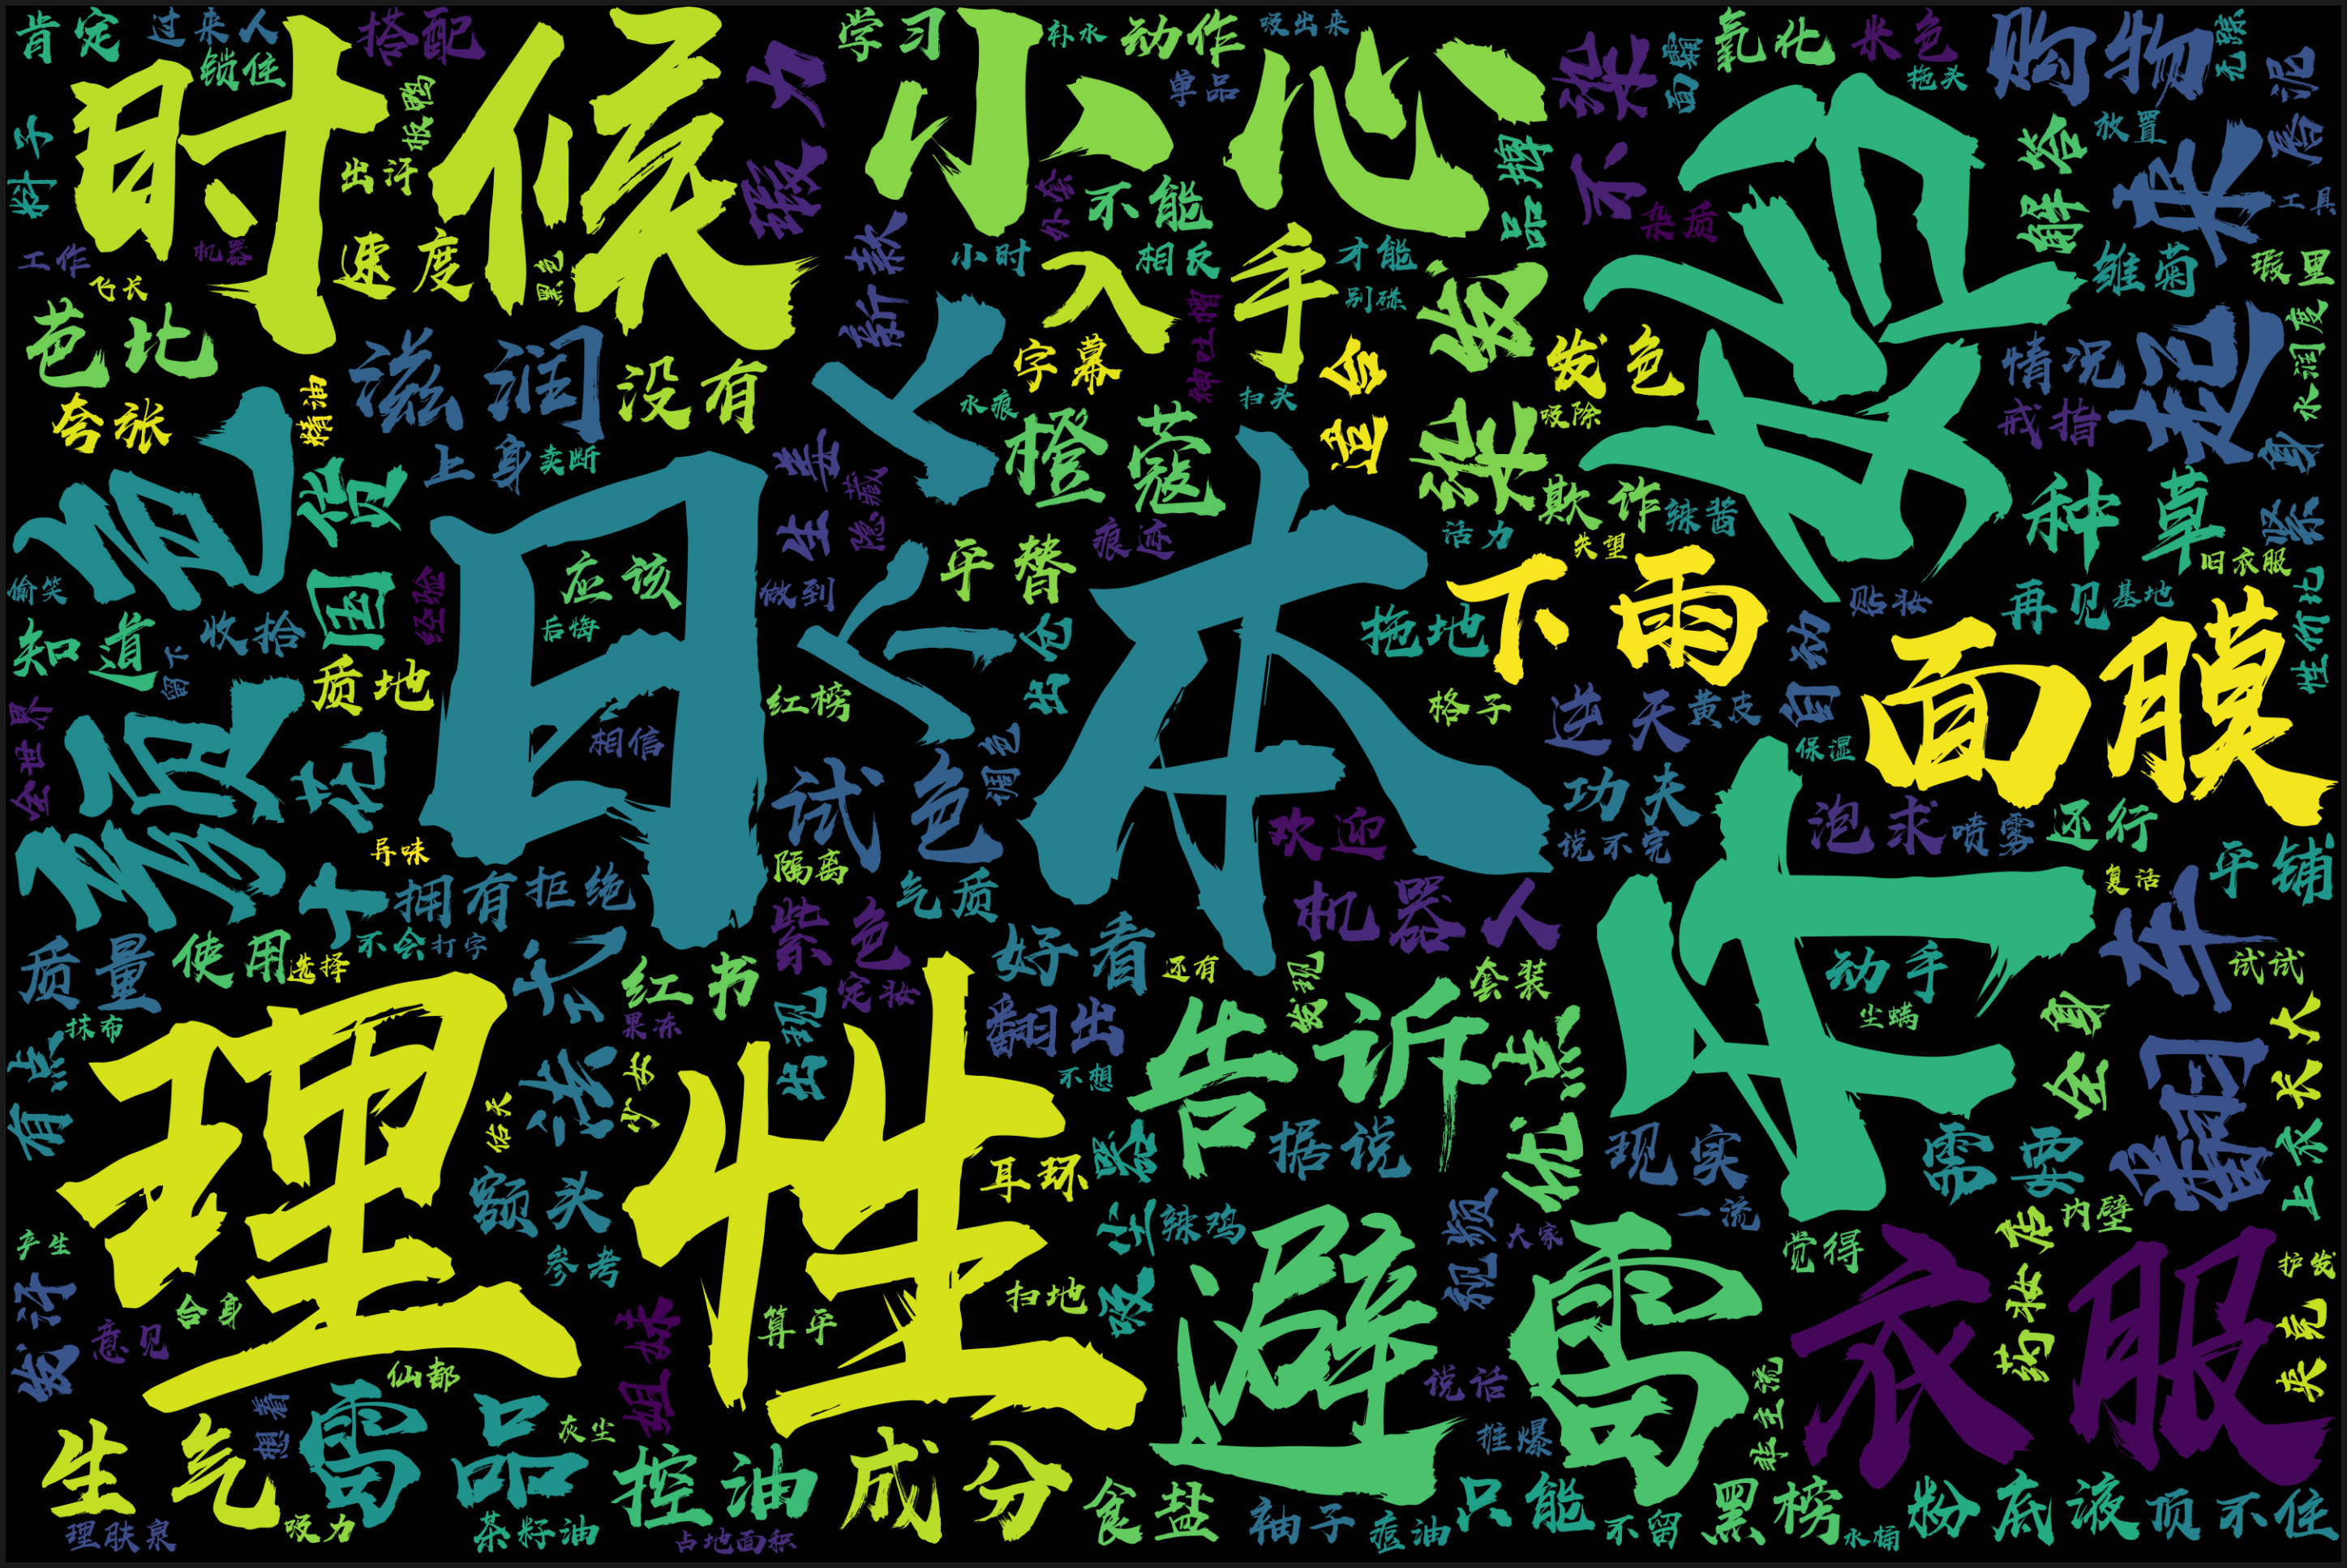

In [16]:
import jieba.analyse

texts = [
    jieba.analyse.textrank(str(row["title"]) + " " + str(row["content"]), topK=50, withWeight=True)
    for _, row in sample_df[sample_df['category']=='N'].iterrows()
]
result = {}

for text in texts:
    for list in text:
        result[list[0]] = (list[1] + result[list[0]]) if list[0] in result else list[1]

generate_word_cloud(result)